In [1]:
import matplotlib.pyplot as plt
import torch
import numpy
import pandas as pd
import pickle
import tqdm
import glob
import os
import matplotlib.patches as mp
from scipy.ndimage import gaussian_filter
from cv2 import resize
from PIL import Image
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from skimage.morphology import remove_small_objects, remove_small_holes

/scratch/ipykernel_237426/978190780.py:14: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [2]:
import numpy as np
from skimage.util.shape import view_as_windows
import cv2

In [3]:
from vis.wsi import WSI

In [4]:
%matplotlib inline

In [5]:
def get_tissue_map(mask, patch_size=224, mag=10, mag_mask=0.25):
    scale_factor = mag/mag_mask
    block_size = int(patch_size/scale_factor)
    h,w = mask.shape
    new_h = int(h / (patch_size/scale_factor) * block_size)
    new_w = int(w / (patch_size/scale_factor) * block_size)
    mask = resize(mask, (new_h, new_w))
    patch_stacked_mask = view_as_windows(mask, (block_size, block_size), step=block_size)
    patch_tissue_pct = patch_stacked_mask.mean(axis=(2, 3))
    return patch_tissue_pct

In [6]:
def get_attention_map(attn_map, patch_i = -1):
    mask = attn_map[patch_i+1,1:].view(20,20)
    n = (mask > 0).sum()
#     return torch.log(mask*n)
    return mask*n

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

In [7]:
def get_gf(attn_map, sigma=1):
    aa = attn_map.copy()
    aa[np.isnan(aa)] = 0
    aa = gaussian_filter(aa, sigma=sigma)
    aa = aa * ~np.isnan(attn_map)
    aa[aa==0] = np.nan
    return aa

In [8]:
def compress_global_attention(model_name, study, epoch, svs_dir, layers_i = 'None', head_i = 'None', plot_result=False):

    print(f"features/{model_name}/{layer_i}-{head_i}/{study}/{epoch}/meta.pickle")
    df = pd.read_pickle(f"features/{model_name}/{layer_i}-{head_i}/{study}/{epoch}/meta.pickle")
    svs_ids = df.id_svs.unique().tolist()
    df.drop_duplicates('id_svs', inplace=True)

    attn_maps = {}
    cnts_maps = {}
    dims_maps = {}
    thumbnails = {}
    pattern = f"features/{model_name}/{layer_i}-{head_i}/{study}/{epoch}/*.pickle"
    files = glob.glob(pattern)
    for fname in tqdm.tqdm(files):
        if os.path.basename(fname) == 'meta.pickle':
            continue
        with open(fname, 'rb') as f:
            aa = pickle.load(f)
        n_samples = aa['ids'].size(0)
        for i in range(n_samples):
            pos_x, pos_y = aa['pos_tile'][i].squeeze().tolist()
            svs_id = str(aa['ids'][i].item())
            if svs_id not in attn_maps.keys():
                svs_path = df.loc[df.id_svs_num == int(svs_id), 'svs_path'].item()
                wsi = WSI(svs_path)
                mag_mask = 1.25
                thumbnail = wsi.downsample(mag_mask)
                thumbnail, (max_x, max_y), (new_x, new_y) = crop_prop_img(thumbnail)
                attn_maps[svs_id] = np.zeros((max_x+20, max_y+20))
                cnts_maps[svs_id] = np.zeros((max_x+20, max_y+20))                    
                dims_maps[svs_id] = (max_x, max_y)
                thumbnails[svs_id] = thumbnail
            attn_map_i = get_attention_map(aa['attn'][i], -1).numpy()
            num_patches = (attn_map_i > 0).sum()
            attn_maps[svs_id][pos_x:(pos_x+20),pos_y:(pos_y+20)] += attn_map_i
            cnts_maps[svs_id][pos_x:(pos_x+20),pos_y:(pos_y+20)] += attn_map_i != 0


        
    for svs_id in list(attn_maps.keys()):
        max_x, max_y = dims_maps[svs_id]
        attn_maps[svs_id] = attn_maps[svs_id]/cnts_maps[svs_id]
        attn_maps[svs_id] = attn_maps[svs_id][:max_x, :max_y]
        attn_maps[svs_id] = attn_maps[svs_id].swapaxes(1,0)
        
        if plot_result:
            fig = plt.figure(figsize=(8,8))
            axis_1 = fig.add_axes([0,0,1,1], label='1')
            axis_2 = fig.add_axes([0,0,1,1], label='2')
            axis_1.imshow(thumbnails[svs_id])
            axis_1.axis('off')

            axis_2.imshow(attn_maps[svs_id], alpha=0.4, cmap='coolwarm')
            axis_2.axis('off')
            plt.show()


    save_loc = f"features_agg/{model_name}/{layer_i}-{head_i}/{study}/{epoch}/"
    os.makedirs(save_loc, exist_ok=True)
    with open(save_loc+'attn_map.pickle', 'wb') as f:
        pickle.dump(attn_maps, f)

            

In [9]:
def restore_agg_attn_map(row):
    model_name, study, epoch, svs_dir = row['model_name'], row['study'], row['epoch'], row['svs_dir']
    with open(f"features_agg/{model_name}/None-None/{study}/{epoch}/attn_map.pickle", "rb") as f:
        attn_maps = pickle.load(f)
    return attn_maps

def get_diff_map(meta_ckp, id_ft, id_pt, id_svs):
    row_ft = meta_ckp.iloc[id_ft]
    attn_maps_ft = restore_agg_attn_map(row_ft)
    if id_pt is None:
        name = f"ft{row_ft['model_name']}-pt-None"
        return attn_maps_ft[id_svs], name, row_ft['study']
    row_pt = meta_ckp.iloc[id_pt]
    attn_maps_pt = restore_agg_attn_map(row_pt)
    name = f"ft{row_ft['model_name']}-pt{row_pt['model_name']}"
    fig, axes = plt.subplots(1,3, figsize=(10,15))
    attn_maps_diff = attn_maps_ft[id_svs] - attn_maps_pt[id_svs]
    axes[0].imshow(attn_maps_ft[id_svs], cmap='coolwarm')
    axes[0].axis('off')
    axes[1].imshow(attn_maps_pt[id_svs], cmap='coolwarm')
    axes[1].axis('off')
    axes[2].imshow(attn_maps_diff, cmap='coolwarm')
    axes[2].axis('off')
    plt.show()
    return attn_maps_diff, name, row_ft['study'], attn_maps_ft[id_svs], attn_maps_pt[id_svs]

def get_correct_thumbnail(meta_ckp, id_row, id_svs):
    row = meta_ckp.iloc[id_row]
    df_meta = pd.read_pickle(f"features/{row['model_name']}/None-None/{row['study']}/{row['epoch']}/meta.pickle")
    row_svs = df_meta.loc[df_meta.id_svs_num == int(id_svs)].iloc[0]
    svs_path = row_svs['svs_path']
    wsi = WSI(svs_path)
    mag_mask = 1.25
    thumbnail = wsi.downsample(mag_mask)
    return wsi, thumbnail


In [10]:
def is_purple_dot(r, g, b):
    rb_avg = (r + b) / 2
    if r > g - 10 and b > g - 10 and rb_avg > g + 20:
        return True
    return False
def is_purple(crop):
    crop = crop.reshape(2,2,3)
    num_purple_squares = 0
    for x in range(crop.shape[0]):
        for y in range(crop.shape[1]):
            r = crop[x, y, 0]
            g = crop[x, y, 1]
            b = crop[x, y, 2]
            if is_purple_dot(r, g, b):
                return True
    return False
def filter_purple(img):
    h,w,d = img.shape
    step = 2
    img_padding = np.zeros((h+step-1,w+step-1,d))
    img_padding[:h,:w,:d] = img
    img_scaled = view_as_windows(img_padding, (step,step,3), 1)
    return np.apply_along_axis(is_purple, -1, img_scaled.reshape(h,w,-1)).astype(int)

In [11]:
def crop_prop_img(img):
    size_y, size_x, _ = img.shape
    down_scale = 10/mag_mask/224
    max_x, max_y = int(size_x*down_scale), int(size_y*down_scale)
    new_y, new_x = int(max_x/down_scale), int(max_y/down_scale)
    img = img[:new_x, :new_y, :]
    return img, (max_x, max_y), (new_x, new_y)

In [12]:
def plot_local_attention(
            wsi, 
            attn_map3, 
            vmin, 
            vmax, 
            pos_x, 
            pos_y, 
            region_size, 
            magnification, 
            annotation=None,
            save_fig=False,
            save_dir=""):
        attn_clip = attn_map3[(max(0, pos_y)):(pos_y+region_size), (max(0,pos_x)):(pos_x+region_size)]
        region_name = f"r_{region_size}-m_{str(magnification)}-{pos_x}_{pos_y}"
        tile = wsi.get_region(pos_x, pos_y, region_size*magnification/1.25, magnification, 1.25)
        fig = plt.figure(figsize=(8,8))
        plt.imshow(tile)
        plt.axis('off')
        if save_fig:
            plt.savefig(save_dir + f"{region_name}-tile.svg",bbox_inches='tight',pad_inches = 0)
            plt.close()
        else:
            plt.show()

        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_axes((0,0,1,1), label='wsi')
        ax2 = fig.add_axes((0,0,1,1), label='attn')
        ax1.imshow(attn_clip, vmin=vmin, vmax=vmax, alpha=1.0, cmap='coolwarm')
        ax1.axis('off')        
        ax2.imshow(tile, alpha=0.5)
        ax2.axis('off')

        if annotation is None:
            pass
        else:
            for pos in annotation:
                pos_x, pos_y, region_size = pos
                rect = mp.Rectangle((pos_x,pos_y), region_size, region_size, linewidth=2, edgecolor='black', facecolor='none')
                ax2.add_patch(rect)     
        if save_fig:
            plt.savefig(save_dir + f"{region_name}-overlay.svg",bbox_inches='tight',pad_inches = 0)
            plt.close()
        else:
            plt.show()


def get_local_attention_overlay(
        save_dir, 
        thumbnail,
        attn_map3, 
        wsi, 
        vmin, 
        vmax, 
        sel_region,
        sel_patch,
        save_fig=False
    ):    
    
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    ax.imshow(attn_map3)
    for sel_i in [sel_region]+sel_patch:
        pos_x, pos_y, region_size, _ = sel_i
        rect = mp.Rectangle((pos_x,pos_y), region_size, region_size, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
    pos_x, pos_y, region_size, magnification = sel_region
    annotation = []
    for sel_i in sel_patch:
        pos_xp, pos_yp, region_size_p, _ = sel_i
        annotation.append([pos_xp-pos_x, pos_yp-pos_y,region_size_p])
    plot_local_attention(wsi, attn_map3, vmin, vmax, pos_x, pos_y, region_size, magnification, annotation, save_fig=save_fig, save_dir=save_dir)
    for i, sel_i in enumerate(sel_patch):
        pos_xp, pos_yp, region_size, magnification = sel_i
        plot_local_attention(wsi, attn_map3, vmin, vmax, pos_xp, pos_yp, region_size, magnification, save_fig=save_fig, save_dir=save_dir)

def complete_pipeline(
        svs_id, 
        ft_id, 
        pt_id, 
        save_fig = True, 
        cl = 0.2, 
        ch=0.8, 
        sel_region=None, 
        sel_patch=None,
        alpha=0.3):
    attn_map, map_name, study, _, _ = get_diff_map(df_meta_ckp, ft_id, pt_id, svs_id)
    wsi, thumbnail = get_correct_thumbnail(df_meta_ckp, ft_id, svs_id)
    print(thumbnail.shape)

    thumbnail2, (max_x, max_y), (new_x, new_y) = crop_prop_img(thumbnail)

    attn_map[np.isnan(attn_map)] == 0
    attn_map = resize(attn_map, (new_y, new_x), interpolation=cv2.INTER_LINEAR)

    old_x, old_y, _ = thumbnail.shape
    print(wsi.svs_path)
    print(map_name)

    # masks = {}
    if wsi.svs_path not in masks.keys():
        mask = filter_purple(thumbnail2)
        masks[wsi.svs_path] = remove_small_holes(mask==1,400)
    mask = masks[wsi.svs_path]

    id_patient = wsi.svs_path.split('/')[-1][:12]
    save_dir = f"output/visualization/{study}/{id_patient}/{map_name}/"
    print(save_dir)
    os.makedirs(save_dir, exist_ok=True)


    attn_map2 = attn_map.copy()
    attn_map2[np.isnan(attn_map2)] = 0
    attn_map3 = mask*attn_map2
    attn_map3[attn_map3 == 0] = np.nan 

    vmin, vmax = np.nanquantile(attn_map3, cl),np.nanquantile(attn_map3, ch)
    print(vmin, vmax)

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_axes((0,0,1,1), label='wsi')
    ax2 = fig.add_axes((0,0,1,1), label='attn')  

    am = attn_map3.copy()
    am[am > vmax] = vmax
    am[am < vmin] = vmin
    ax1.imshow(attn_map3, alpha=1.0, vmin=vmin, vmax=vmax, cmap='coolwarm')
    ax1.axis('off')
    
    ax2.imshow(thumbnail2, alpha=0.5)
    ax2.axis('off')

    pos_x, pos_y, region_size,_ = sel_region
    rect = mp.Rectangle((pos_x,pos_y), region_size, region_size, linewidth=2, edgecolor='black', facecolor='none')
    ax2.add_patch(rect)
    if save_fig:
        plt.savefig(save_dir+'overview-combined.svg',bbox_inches='tight',pad_inches = 0)
        plt.close()
    else:
        plt.show()

    fig = plt.figure(figsize=(10,10))
    plt.imshow(thumbnail2)
    plt.axis('off')
    if save_fig:
        plt.savefig(save_dir+'overview-thumbnail.svg',bbox_inches='tight',pad_inches = 0)
        plt.close()
    else:
        plt.show()

    fig = plt.figure(figsize=(10,10))
    plt.imshow(attn_map3, vmin=vmin, vmax=vmax, cmap='coolwarm')
    plt.axis('off')
    if save_fig:
        plt.savefig(save_dir+'overview-heatmap.svg',bbox_inches='tight',pad_inches = 0)
        plt.close()
    else:
        plt.show()
    
    get_local_attention_overlay(
        save_dir, 
        thumbnail, 
        attn_map3, 
        wsi, 
        vmin, 
        vmax, 
        sel_region=sel_region,
        sel_patch=sel_patch,
        save_fig=save_fig
    )

    return attn_map3, thumbnail2, wsi
        

In [13]:
# compile the meta information

meta_dict = [
    {
        "order": 0,
        "name": "TCGA_BRCA_pretrained",
        "study": 'TCGA_BRCA',
        "model_name": "-20221013_201713",
        "epoch": "0500"
    },
    {
        "order": 1,
        "name":"TCGA_BRCA_classification",
        "study": "TCGA_BRCA",
        "model_name": '-20230221_000020-1',
        "epoch": "0010"
    }
]

svs_dirs = {
    'TCGA_BRCA':'Breast',
    'TCGA_KIRC':'Kidney',
    'TCGA_KIRP':'Kidney',
    'TCGA_KICH':'Kidney',
    'TCGA_GBM': 'Brain',
    'TCGA_LGG': 'Brain',
    'DHMC_RCC': 'WSI_RCC',
    'TCGA_LUAD': 'Lung',
    'TCGA_LUSC': 'Lung',
    'TCGA_OV': 'Ovary',
    'TCGA_COAD': 'Colorectal'
}

svs_dir_mapping = pd.DataFrame(svs_dirs, index=[0]).transpose().reset_index()
svs_dir_mapping.columns = ['study','svs_dir']

df_meta_ckp = pd.DataFrame(meta_dict)
df_meta_ckp = df_meta_ckp.merge(svs_dir_mapping, on='study')

In [14]:
df_meta_ckp = df_meta_ckp.sort_values('order').reset_index(drop=True)

In [15]:
# append svs-path infomation to the meta file

layer_i = head_i = 'None'

for i, row in df_meta_ckp.iterrows():
    study = row['study']
    model_name = row['model_name']
    epoch = row['epoch']
    svs_dir = row['svs_dir']
    
    try:
        df_meta = pd.read_pickle(f'features/{model_name}/{layer_i}-{head_i}/{study}/{epoch}/meta.pickle')
    except Exception as e:
        print(e)
        continue
    
    if 'svs_path' in df_meta.columns:
        continue
    
    res = []
    for i_i, row_i in df_meta.drop_duplicates('id_svs').iterrows():
        svs_id = row_i['id_svs']
        file_id = df_meta.loc[df_meta.id_svs == svs_id].id_svs.tolist()[0]
        if study.split('_')[0] == 'TCGA':
            svs_path = glob.glob(f"/pool2/data/WSI_TCGA/{svs_dir}/*/{file_id}.svs")[0]
        elif study == 'DHMC_RCC':
            svs_path = glob.glob(f"/pool2/data/{svs_dir}/dataset/*/*/{file_id}.svs")[0]
        res.append((file_id, svs_path))
    svs_path_mapping = pd.DataFrame(res, columns=['id_svs','svs_path'])
    df_meta = df_meta.merge(svs_path_mapping, on='id_svs')
    df_meta.to_pickle(f'features/{model_name}/{layer_i}-{head_i}/{study}/{epoch}/meta.pickle')
    print(f'features/{model_name}/{layer_i}-{head_i}/{study}/{epoch}/meta.pickle')
    

In [16]:
df_meta_ckp

order                      name      study          model_name epoch  \
0      0      TCGA_BRCA_pretrained  TCGA_BRCA    -20221013_201713  0500   
1      1  TCGA_BRCA_classification  TCGA_BRCA  -20230221_000020-1  0010   

  svs_dir  
0  Breast  
1  Breast

In [17]:
mag_mask = 1.25

# create masks if not exist
try:
    print(masks.keys())
except:
    masks = {}

In [18]:
for i, row in df_meta_ckp.iterrows():
    print(i, row)
    study = row['study']
    model_name = row['model_name']
    epoch = row['epoch']
    svs_dir = row['svs_dir']
    print('<>'*30)
    print(model_name, study, epoch, svs_dir)
    compress_global_attention(model_name, study, epoch, svs_dir, plot_result=False)

0 order                            0
name          TCGA_BRCA_pretrained
study                    TCGA_BRCA
model_name        -20221013_201713
epoch                         0500
svs_dir                     Breast
Name: 0, dtype: object
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
-20221013_201713 TCGA_BRCA 0500 Breast
features/-20221013_201713/None-None/TCGA_BRCA/0500/meta.pickle


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:45<00:00,  2.63it/s]
/scratch/ipykernel_237426/3483166315.py:43: RuntimeWarning: invalid value encountered in true_divide
  attn_maps[svs_id] = attn_maps[svs_id]/cnts_maps[svs_id]


1 order                                1
name          TCGA_BRCA_classification
study                        TCGA_BRCA
model_name          -20230221_000020-1
epoch                             0010
svs_dir                         Breast
Name: 1, dtype: object
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
-20230221_000020-1 TCGA_BRCA 0010 Breast
features/-20230221_000020-1/None-None/TCGA_BRCA/0010/meta.pickle


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:46<00:00,  2.54it/s]
/scratch/ipykernel_237426/3483166315.py:43: RuntimeWarning: invalid value encountered in true_divide
  attn_maps[svs_id] = attn_maps[svs_id]/cnts_maps[svs_id]


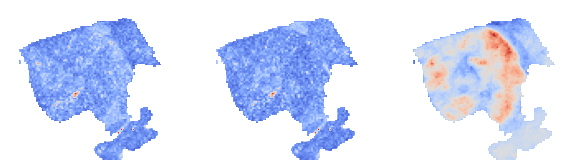

(2619, 2820, 3)
svs/Breast/cc4be7bc-ac0d-4c2c-8b7b-1da8e59ce1b8/TCGA-BH-A1FN-01Z-00-DX1.CEE3C59B-6CF0-4D41-8334-6067BB5A8BF7.svs
ft-20230221_000020-1-pt-20221013_201713
output/visualization/TCGA_BRCA/TCGA-BH-A1FN/ft-20230221_000020-1-pt-20221013_201713/
-0.012139575551957747 0.06746315184881797


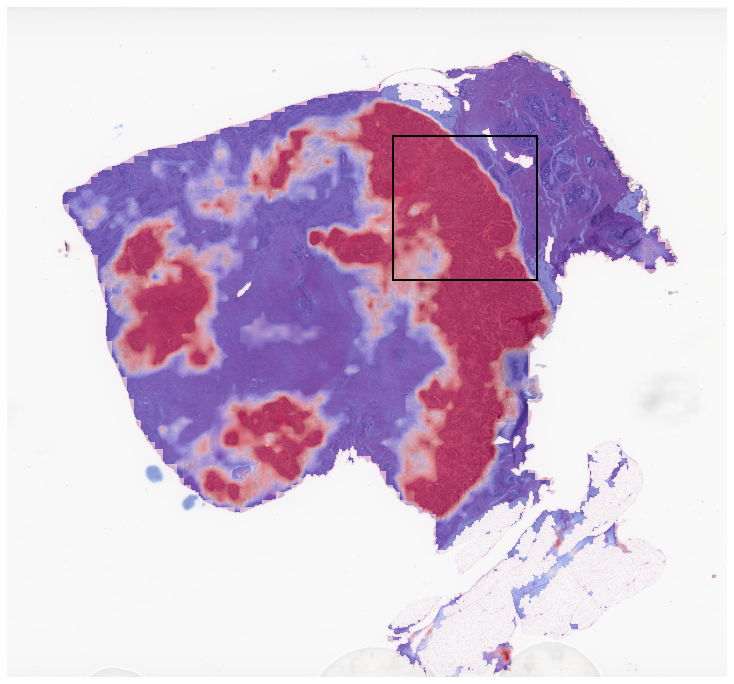

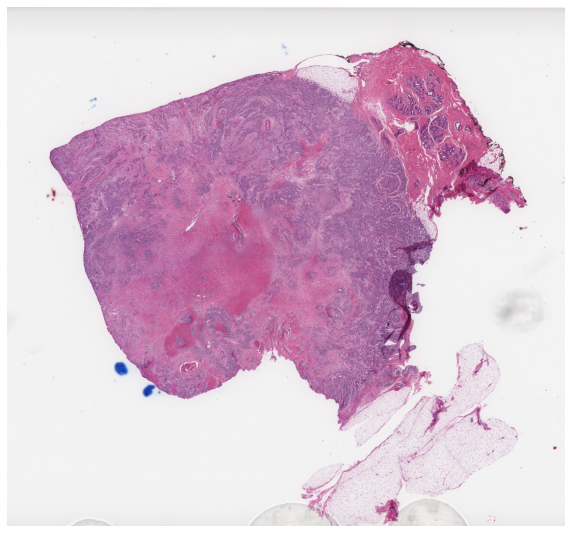

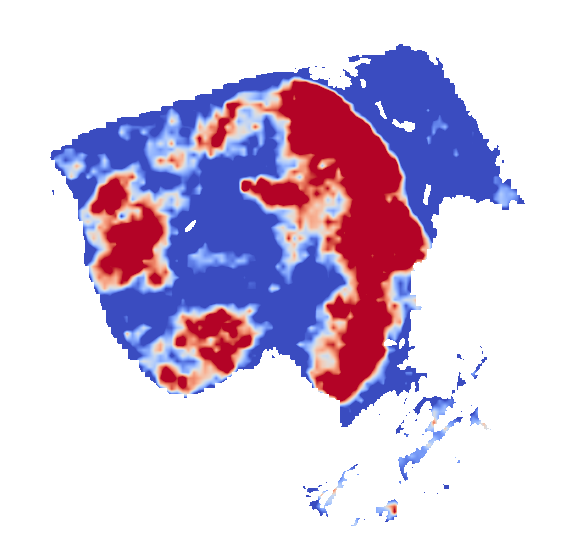

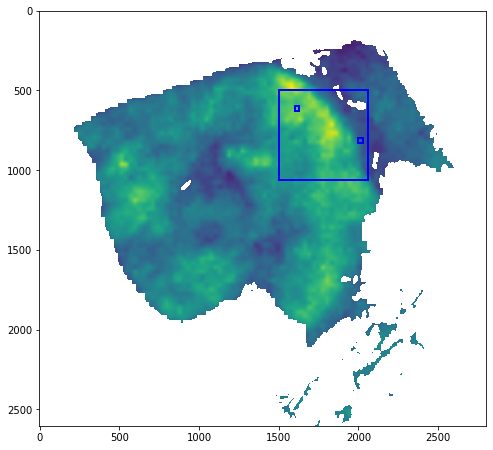

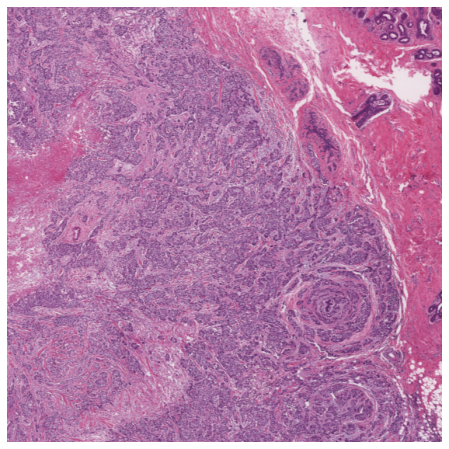

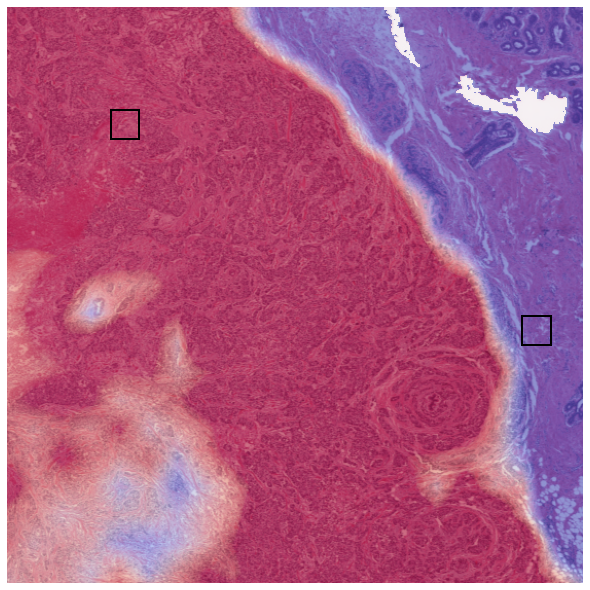

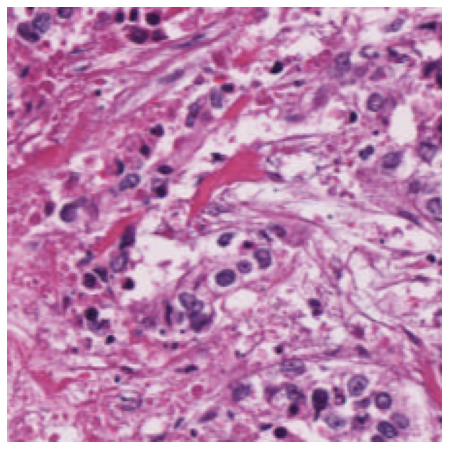

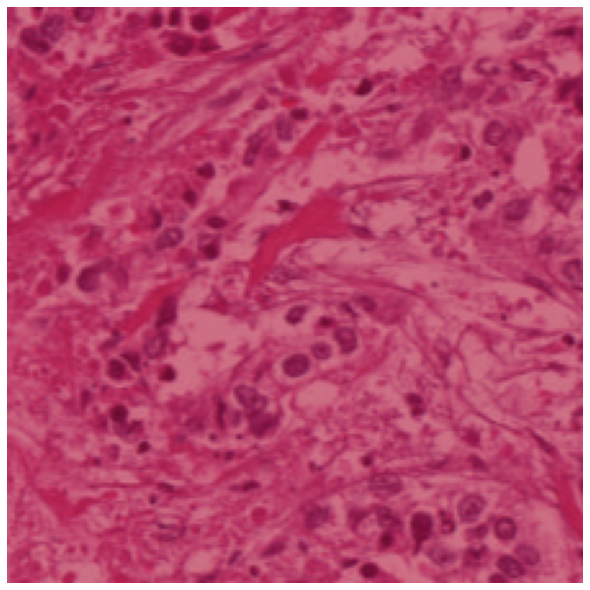

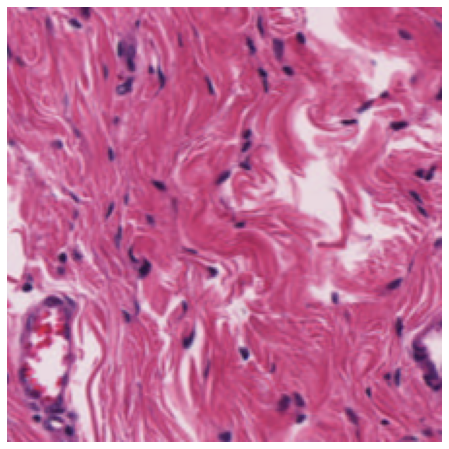

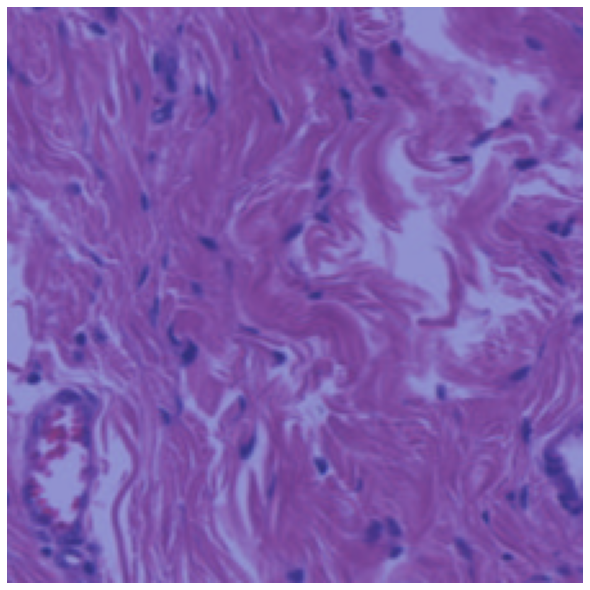

In [19]:
_ = complete_pipeline('0', 1, 0, 
                      sel_region=(1500,500,560,1.25), 
                      sel_patch=[(1500+100,500+100,28,10),(1500+500,500+300,28,10)], 
                      save_fig=False, cl=0.4, ch=0.8) 